## Task 1: (Next) Pixel prediction (35 pts)
In this part, you will train a **many-to-many** recurrent model: at each time $t$, the model receives as input a pixel value $x_t$ and tries to predict the next pixel in the images $x_{t+1}$ based on the current input and the recurrent state. Thus, your output function is now a probability over the value of pixel $x_{t+1}$ -- which can be either $0$ or $1$ (black or white).
\begin{equation}
    \hat{p}(x_{t+1}|x_{1:t}) = g(x_{t}, h_{t}, c_{t})
\end{equation}
Once we get to observe the actual value of $x_{t+1}$ at the next time-step, we can compute the cross-entropy between our predicted probability $\hat{p}(x_{t+1}|x_{1:t})$ and the observed value (pixel in the image). We can (and will) do that for every time-step prediction within a sequence. This will provide us with the training signal for optimizing the parameters of the mapping $g$ and the recurrent connections -- remember these are shared!, they do not change with $t$.





### Optimization
Use the Adam optimizer (with default settings other than the learning rate) for training.

**[Optional]** Sometimes dropout has been shown to be beneficial in training recurrent models, so feel free to use it or any other form of regularization that seems to improve performance. It might be also worth trying out batch-normalization. [Reference](https://arxiv.org/pdf/1603.09025.pdf).

### Models: Your models will have the following structure:
1. [(Red Block)] The *input* (current binarised row of pixels) can be fed directly into the recurrent connection without  much further pre-processing.
2. [(Blue Block)] The *output* (probabilities over the activation of the pixel) is produced by looking at the last output of the recurrent units, transforming them via an affine transformation.
3. [(Green Block)] For the *recurrent* part of the network, please implement and compare the following architectures:
    * LSTM with 32 units. **[15 pts]**
    
    **OR**
    
    * GRU with 32 units. **[15 pts]**

Your network should look like:
\begin{equation}
\textrm{Input} \Rightarrow \textrm{RNN cell} \Rightarrow \textrm{Relu} \Rightarrow \textrm{Fully connected} \Rightarrow \textrm{Relu} \Rightarrow \textrm{Fully connected} \Rightarrow \textrm{Output}
\end{equation}
You might find the function `tf.nn.dynamic_rnn` useful.

### Hyper-parameters 
For all cases train the model with these hyper-parameter settings:

- *num_epochs*=5, *learning_rate*=0.001, *batch_size*=256, *fully_connected_hidden_units=64*

With these hyper-parameters you should give you a good perfomance on both GRUs/LSTMs. It is worth noting that in $5$ epochs the model has yet converged, but in the interest of time (the training should have $\approx$ 1h). That being said, feel free to try other settings, there are certainly better choices, but please report the results with these exact hyper-parameters and/or train for longer -- the models should still improve (convergence is achieved around 25-30 epochs). 

### Tasks:

1) Implement and train the previously described model (choose either GRU **or** LSTM). Please report the *cross-entropy* on the *test set* and *training set* of the models trained. Use the `plot_summary_table` method below to format the table. Provide the learning curves (both training and testing loss) -- choose appropiate reporting interval here (at least 20 points).

2) Using the previously trained model, visualize the 1-step predictions, 10-step predictions, one row prediction (28 steps) and filling out the image (fill out all the pixels using the recurrent model). 

*   **Generate a small in-painting dataset.** Sample $100$ images from your test set. Mask/Remove the last $300$ pixels (roughly 10 rows and a half).

*   **Predict missing parts and compare with GT**. Given the above generated partial sequences as input to your train models, generate the continuation of these masked images (for the next 1, 10, 28, 300 pixels).
Report the cross-entropy of your in-paintings for the trained model at beginning of training(0 epochs), after 1 epoch and at the end of training. Discuss the results: contrasting long/short time prediction; compare these with the cross-entropy of the ground truth images. For multiple steps in-paintings, average the loss over $10$ samples. **[10 pts]**

For a single pixel, the cross entropy loss starts relatively high, then gradually gets lower as the accuracy improves. For 10, 28 and 300 pixels, the loss fluctuates a lot, before finally getting lower and lower as the model learns. This is because the model has not yet learned to predict the next pixel very accurately and so errors in bootstrapped predictions accumulate quickly, and because the variation in the prediction is much higher in the earlier training iterations, this results in high-variance error accumulation and thus in-filling accuracy. The more pixels we are in-filling, the more this error accumulation applies. I also found that using batch-normalization degraded the accuracy of these long time in-fills (especially for 300 pixels). This may be because the normalization "flattens out" magnitudes which carry longer term information (for example, when starting a new row).

*   **Visualize completing the image**. Pick out $3$ examples from your in-painting dataset to visualize  the resulting images -- this can be done at random, but should include *a successful example, failure example and one that displays high variance between samples.* For each example picked, please provide $5$ samples for the last three scenarios (10, 28, 300 pixels) and $1$ for the 1-pixel prediction -- total 16 samples/exampls. The samples should be generated recursively by sampling the generative process provided by the trained recurrent connections. Total number of in-painting to report: 16 samples x 3 examples = 48 **[10 pts]**



## Task 2: Using pixel-to-pixel: In-painting task (25 pts)

Using the models trained in the previous section, please in-paint the missing pixels in the following datasets:
* [One-pixel missing](https://github.com/dianaborsa/compgi22_dl_cw4/blob/master/one_pixel_inpainting.npy)
* [Window of 2x2 pixels missing](https://github.com/dianaborsa/compgi22_dl_cw4/blob/master/2X2_pixels_inpainting.npy)

This is similar to Task 1.b, but now you have information not only about the past(previous pixels in the image) but also future (pixels that come after your predictive target)

### Results
1) Provide the formula used to compute the probability over the missing pixel and respectively for the missing patch **[5+5 pts]**

$N = $ number of pixels in image ($28 \times 28 = 784$)

$m \in \{1, 4\} = $ number of missing pixels to in-paint

$X \in [0,1]^m = $ a possible in-painting, with $m$ pixels

$\mathbb{X} \in [0,1]^{N - m} = $ image pixels exlcuding the missing pixels for in-painting

$^{(X)}\mathbb{X} \in [0,1]^{N} = \{x_1, \cdots, x_N\} = $ image pixels including the in-painting $X$

$\mathbb{P}(\mathbb{X}) = \mathbb{P}(x_1) \prod_{q = 2}^{|\mathbb{X}|} \mathbb{P}(x_q \,\, | \,\, \mathbb{X}_{1:q-1}) \,\,\,\,\,$ (Same for $^{(X)}\mathbb{X}$)

$\mathbb{P}(\hat{X} \,\, | \,\, \mathbb{X}) = \frac{\mathbb{P}(^{(\hat{X})}\mathbb{X})}{\mathbb{P}(\mathbb{X})} = \frac{\mathbb{P}( ^{(\hat{X})}\mathbb{X})}{\sum_X \mathbb{P}(^(X)\mathbb{X})}$

2) Visualize the most probable in-painting, according to your model. How does this compare to the ground truth? (Compare cross-entropy between your most probable sample and the ground truth). Explain the difference. It is enough to include just one example per task/dataset. **[10 pts]**

Samples evaluated: Visualised sample number 4 / 5 for 1x1 in-painting (digit 9):
The model predicts a pixel where in fact there should be none. This is a case on the edge of a digit where there are many pixels surrounding the missing 1x1 patch, and it's not easy to tell whether it should be painted in. The decision the model makes (to in-paint) conforms with what one might expect given the context - the digit appears more natural, with less stroke thickness variation, with the pixel in-painted.

Visualised sample 5 / 5 for 2x2 pixel in-painting (digit 7):
This is a similar case as the above, except this time the model has decided not to in-paint when it should have. The patch is on the edge of a stroke, but there are fewer surrounding pixels to give the model "a reason" to in-fill. This time the digit does look more natural with the in-painting, as without there is a change in the size of the stroke. However, the thickness of the stroke for the whole digit is higher than usual, so this might be why the model didn't want to make it even thicker, as it would deviate from the average appearance.


# Train Models

Generate summary table of results. This function expects a dict with the
following structure: keys of 'LSTM' (or 'GRU') and the values for each key are a
list of tuples consisting of (test_loss, test_accuracy), and the list is
ordered as the results from 0 epoch (beginning of training), 1 epoch, 5 epochs (or end of training) i.e. expected dictionary (final performace only):

```python
{
  'LSTM': [(loss,acc), (loss, acc), (loss, acc)]
}
```

#Results

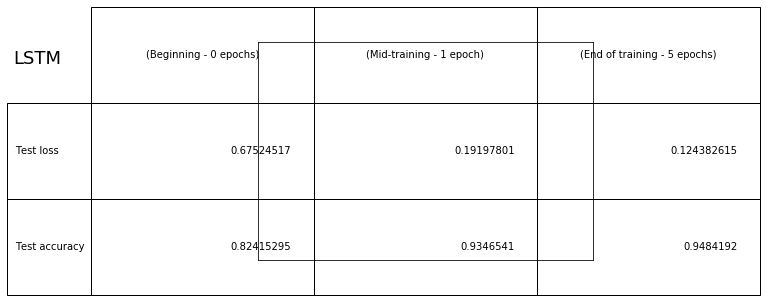

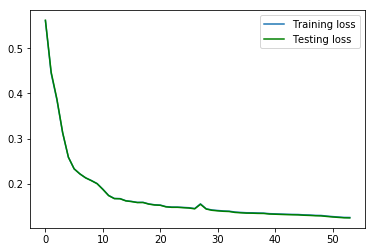

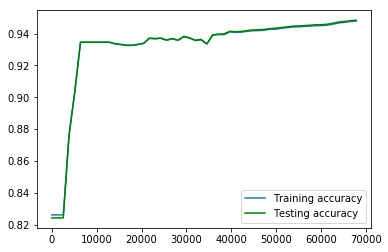

# Pixel prediction

### Generate a small in-painting dataset.
Sample $100$ images from your test set. Mask/Remove the last $300$ pixels (roughly 10 rows and a half).

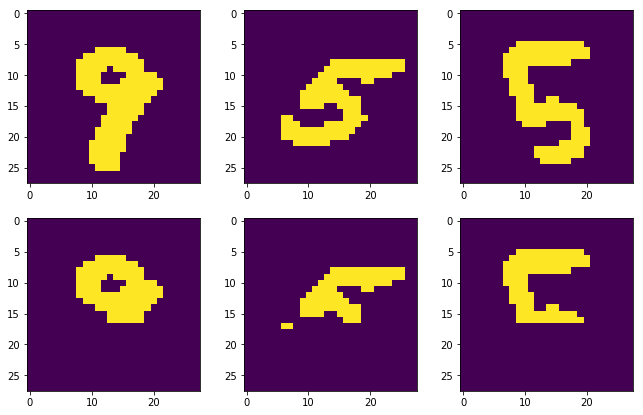

In [0]:
#Sample 100 images + mask

### Predict missing parts and compare with the ground truth. 
Given the above generated partial sequences as input to your train models, generate the continuation of these masked images (for the next 1, 10, 28, 300 pixels).

In [0]:
#Use the model for predictions and compare log likelihood

Ground truth cross entropies for 1, 10, 28 and 300 pixels:
[0.31326163, 0.31326166, 0.31326166, 0.31326166]
Epoch 0, 1 and 5 in-filling cross entropies & accuracies:
  Cross entropy: 1 pixel: 0.6833897, 10 pixels: 0.6932327, 28 pixels: 0.68091625, 300 pixels: 0.6754278
  Cross entropy: 1 pixel: 0.37014905, 10 pixels: 0.9531013, 28 pixels: 0.61352575, 300 pixels: 0.66867864
  Cross entropy: 1 pixel: 0.25383267, 10 pixels: 0.5254516, 28 pixels: 0.32870844, 300 pixels: 0.7219272
  Accuracy: 1 pixel: 0.68, 10 pixels: 0.50400007, 28 pixels: 0.73535717, 300 pixels: 0.8379
  Accuracy: 1 pixel: 0.85, 10 pixels: 0.578, 28 pixels: 0.6882143, 300 pixels: 0.69736665
  Accuracy: 1 pixel: 0.89, 10 pixels: 0.742, 28 pixels: 0.8514286, 300 pixels: 0.81936663


### Visualize completing the image. 
Pick out $3$ examples from your in-painting dataset to visualize  the resulting images -- this can be done at random, but should include \textit{a successful example, failure example and one that displays high variance between samples.}

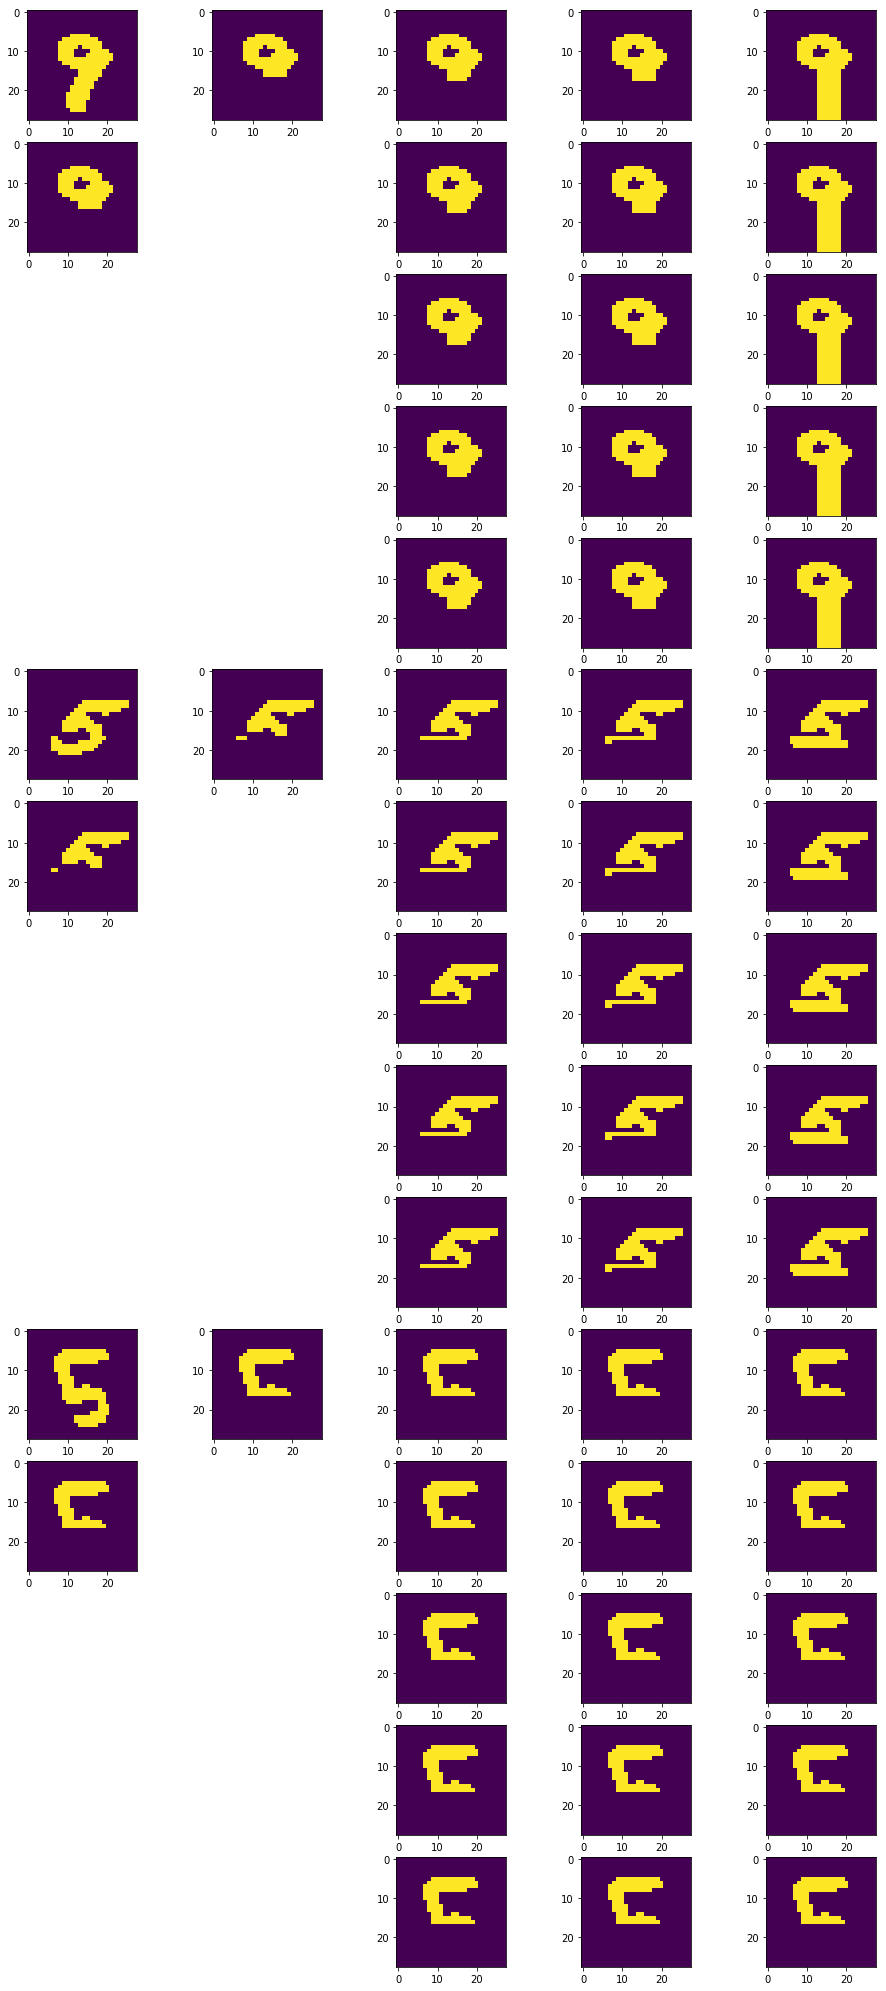

In [0]:
#Visualize samples

# In-painting Task

Loaded dataset has 1000 samples: cropped + GT


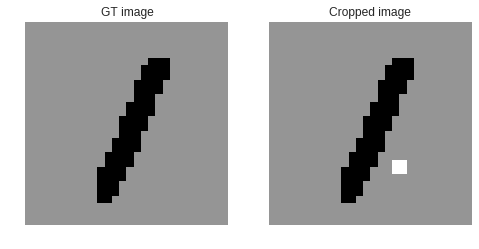

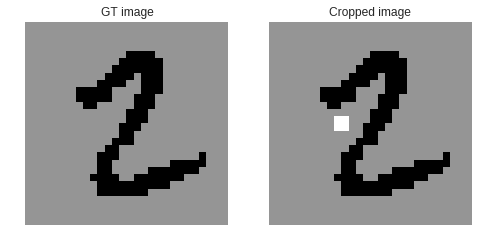

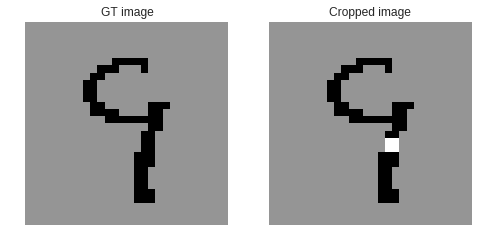

In [6]:
# checking loading

### One-pixel prediction 

 Patches 
 Ground truth 
 In-painting


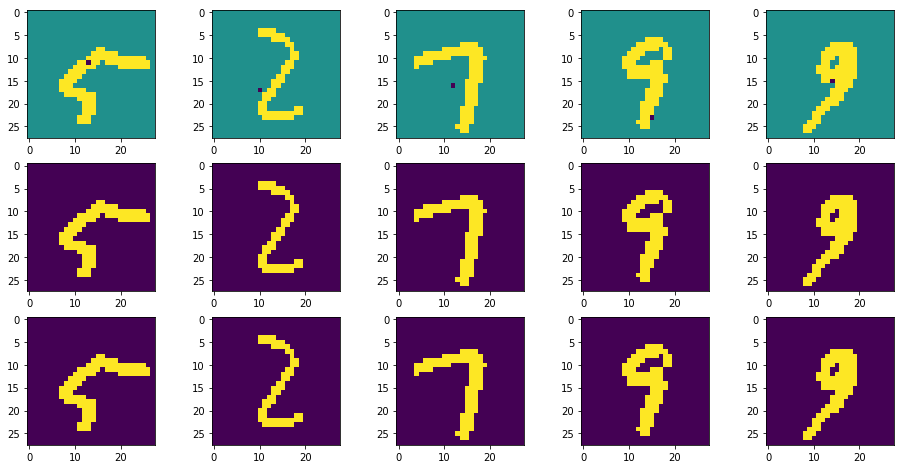

In [0]:
# Predicting the missing pixel
# Visualize samples

### Two-by-two patch prediction 

 Patches 
 Ground truth 
 In-painting


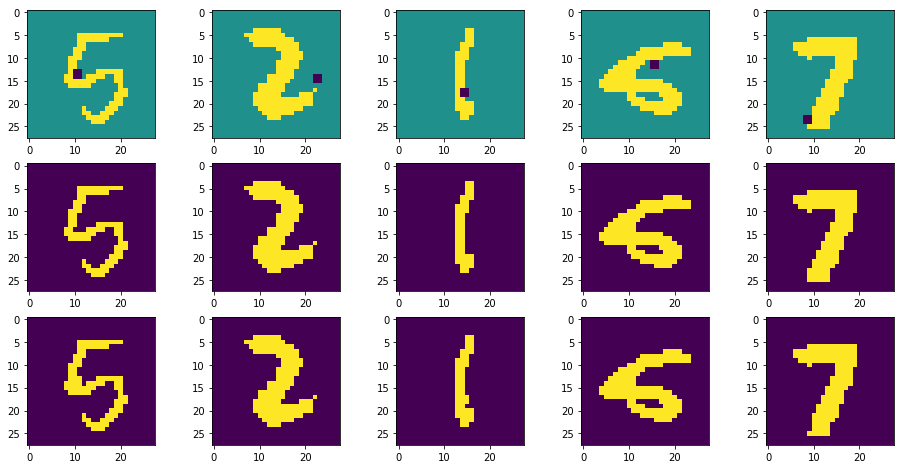

In [0]:
# Predicting the missing pixel
# Visualize samples

----------------------------------------------------------------------

## PART 2: Learning multiple tasks with LSTM-s (40 pts)
(Credits to Pedro Ortega for insipring the task and insights behind it)

### Task Description

Consider the following generative model: 
* We have $3$ symbols that will be generates from a multinomial/categorical distribution, with parameters $\textbf{p}=(p_1, p_2, p_3)$: symbol 1 is generated with probability $p_1$, symbol 2 is generated with probability $p_2$, symbol 3 with probability $p_3$. 
$$X \sim Categorical(3, \textbf{p})$$

* The parameter vector $\textbf{p}$ is drawn from a Dirichlet prior: $$\textbf{p} \sim Dirichlet(\alpha)$$

We are going to use the above to generate sequences (a continuous stream of data/observations), in the following way:
* Step 1: We sample $\textbf{p}$ from the prior
* Step 2: Given this $\textbf{p}$, for $T-1$ time-steps we will generate i.i.d observations by sampling one of the $3$ symbols from the categorical distribution induced by $\textbf{p}$
$$ (X_1, X_2, \cdots X_{T-1}) , s.t. X_i \sim Categorical(3, \textbf{p})$$
* Step 3: At the end of the sequence we append a fourth symbol (RESET): $(X_1, X_2, \cdots X_T, RESET)$
* Step 4: Return to Step 1 and resample $\textbf{p}$. 
* Repeat this 'forever'.

This will give rise to a continuous stream of data, of the form: $ x_1, x_2, \cdots x_{T-1}, RESET, x_{T+1}, x_{T+2}, \cdots x_{2T}, RESET, \cdots, x_{kT+1}, x_{kT+2}, \cdots x_{(k+1)T}, RESET, \cdots$.

Note: Data generation is provided for you in the cell below. (You just need to call the minibatch function to get a sequence of this form).

### Model

We are going to consider an simple LSTM (32 units hidden state) and present this (generated) sequence of data as an input. Similar to the pixel-to-pixel model, at each time step the LSTM will receive one bit of information (gets to observe the symbol recorded at this time step) and need to output the probability distribution for the next symbol. Thus, at time $t$ the LSTM get as input the symbol $x_t$ and will return a probability over the next state $P(x_{t+1}| x_{t}, LSTM_{t-1})$.

### Questions

1) **Without running any experiments (5 pts)**, try to think about the following scenarios and answer these questions: 
* Consider we generate the data with $Dirichlet(\alpha)$, where $\alpha = (10.,1.,1.)$. What do you think the LSTM model will learn, if anything? Remember we are effectively changing the prediction task, every time we are resampling the probability vector $\textbf{p}$. * Hint: Think about the distribution over $\textbf{p}$ that this prior induces. *  

The LSTM model would learn to approximate the current distribution of the symbols coming in through the input at that time - which will almost always be strongly biased towards the first symbol, and so, depending on the number of time steps $T$, and the number of time steps since the last reset symbol $t \mod T$, the model would learn to output symbols based on the probabilities somewhere between the mean of the dirichlet distribution used to generate the multinomial (~$[0.83, 0.083, 0.083]$) if $T$ or $t \mod T$ is low (i.e. 5), and the actual multinomial distribution used to generate the input at the current time step (~$Dirichlet((10, 1, 1))$) if $T$ or $t-kT$ is high, i.e. 20.

* What if we consider a more uniformative prior, like $\alpha=(1.1, 1.1, 1.1)$?  

Now the model would (after enough training samples) learn to output symbols uniformly at the beginning of new sequences (where $t \mod T < \sim 5$), then begin to output symbols according to the incoming input distribution (the multinomial sampled from the dirichlet for the current sequence).

* How does this (learning ability and generalization) depend on the lenght of the tasks $T$ and the unrolling length on the LSTM? It might be helpful to consider the two extremes: 
i) $T=1$ (we reset the task at every time step). What should the model learn in this case?, ii) $T=\infty$ (we sample the task once and keep it forever). What should the model learn in this case? (Answer this for both previous priors)

The learning ability and generalization would be greater when $T$ is large, and also when the unrolling length of the LSTM is large. For $T$, this is because it gives the model more time and therefore more data to approximate the parameters of the multinomial distribution. For the unrolling length, this is because it gives the recurrent model more experience with a changing multinomial, so it can more easily learn to adjust when it sees the reset symbol. When $T$ is small (or 1), the signal contains very little (or no) information about the multinomial distribution that generated it, because there are so few samples. In this case, the model would learn to generate symbols approximately according to the mean of dirichlet prior for the dataset. If $T$ is more than 1 but still low, the conditioning on the output probability due to these few samples for the sequence would be negligible, as they are so noisy. If $T$ is very high (or $\infty$), then we have abundant (or perfect) information about the multinomial distribution that generated the samples just from counting the occurences of each symbol, and the model will comfortably learn to generate output according to this distribution. In either case, if the unrolling length of the LSTM is low, then the model won't learn to reset it's multinomial parameter approximations when it sees the reset symbol, and would therefore have lower accuracy at the beginning of the next sequence.

* Does this increase or descrease the complexity of the prediction problem? What about the ability to generalize to unseen $\textbf{p}$?

With a larger $T$, the complexity of the problem overall (and equally weighted over $t$) is reduced because the output becomes much easier to predict as $t$ increases. For the unrolling length, since the longer the unrolling length, the easier it becomes to learn to reset effectively (better generalization to unseen $\textbf{p}$), then the prediction problem becomes easier and less complex as we no longer have to learn what the reset symbol means from short sequences with only a few of them.

2) **Time to check your intuitions (10 pts)** 

Implement a similar LSTM model as in PART 1. This will take as input a one-hot description of the obsevation ($[1,0,0,0]$ for symbol 1. $[0,1,0,0]$ for symbol 2, $[0,0,1,0]$ for symbol 3, $[0,0,0,1]$ for the RESET symbol). This input is fed into a 32-unit LSTM and LSTM output is processed as before: $\textrm{Relu} \Rightarrow \textrm{Fully connected} \Rightarrow \textrm{Relu} \Rightarrow \textrm{Fully connected} \Rightarrow \textrm{Output}$ . The model will be trained, as before, by cross-entropy on predicting the next symbol. You will notice that the setup is really similar to the previous tasks, so feel free to re-use whenever appropiate.

Train the following models:
* T = 5, and T=20 with the data generated from a Dirichlet with $\alpha = (10.,1.,1.)$. Unrolling length for the LSTM = 100. Minibatch size = 64. (M1, M2)
* T = 5, and T=20 with the data generated from a Dirichlet with$\alpha = (1.3, 1.3, 1.3)$ Unrolling length for the LSTM = 100. Minibatch size = 64. (M3, M4)

Train the models for $1000$ iterations ($1000$ minibatches). Record the training and testing preformance (every 10-20 iterations). Plot the curves over training time. What do you observe? (Is this curve smooth? Do any of them plateau?). **[2x5 pts]**

For the losses, the training curves begin somewhat smooth until the models learn to output particular symbols more often (after around 200 iterations for most models), at which point the learning curves are much more erratic as the models adjust to the minima they've found, before plateauing (for all of them). For the accuracies, this is much less smooth throughout the training. This is probably because the accuracy would only change once the weights in the model are adjusted to be slightly above a threshold that causes the magnitude of one logit to be higher than the rest, and then the observed samples confirm that the symbol does in fact occur more often, reinforcing the new weights' values. While the model has been learning this distribution since early in the training, only at this threshold point does the model start outputting symbols according to what it's learned.

3) **Analysis results (10 pts)**

In this section, we will investigate what the models have actaully learnt. For this we will generate a few test sequences:
* *Test sequence 1*: generate a test sequence that changes tasks every T=5 steps from a a Dirichlet with $\alpha = (10.,1.,1.)$.
* *Test sequence 2*: generate a test sequence that changes tasks every T=5 steps from a a Dirichlet with $\alpha = (1.3,1.3,1.3)$.
* *Test sequence 3*: generate a test sequence that 'changes tasks' every T=5 steps, but keep sampling according to the same probability vector $\textbf{p}=(1,0,0)$ (You can use any of the extreme here).

i) Test the preformance of M1 and M3 and these test sequences. In addition plot the actual prediction the models do (probability of symbols over time). This should give you more insight in what the model does. Does this correspond or contradict your previous intuitions? **[5 pts]**

For the most part the results match my intuition. The differences caused by the size of $T$ are smaller than I expected - in terms of loss and accuracy. This would mean that the extra information in the 15 extra time steps is not huge in comparison to what's already there in the 5. The visualisation shows that the probabilities begin even across symbols after each reset symbol, and quickly learn to approximate the distribution of incoming samples, quickly enough to output a similar distribution but not so quickly that it just repeats the first or second symbol observed.

ii) Repeat the same procedure for task length $T=20$ and models M2 and M4. What do you observe? How do M2 and M4 compare to each other and how to their compare to M1 and M3 (the models trained on the shorter task length). **[5 pts]**

M2 and M4 performed slightly better for sequences 1 and 2, as they have more data from each multinomial to learn from and make future predictions.
Something that was counterintuitive was that all the models performed perfectly on the symbol 1 only task, except M2, which occasionally "forgot" to predict the reset symbol after 19 samples from $p$. It was surprising because the only difference between this model and M4 was that M2 was trained on data using a dirichlet distribution biased to output symbol 1 much more often than the rest. This fact, instead of helping to predict when the input is \textit{only} symbol 1, causes the magnitude of the symbol 1 logit to sometimes be higher than that of the reset symbol when the reset symbol is due. This shows that despite or even due to the specialisation in training, the model is less general and less robust in practice.

4) **Comparison to the Bayesian update (15 pts)**

Going back to the generative process in the task description. For a given prior, for each the mini-tasks (selecting/sampling a $\textbf{p}$), one could compute the Bayesian posterior at each time step.  We start with a prior and every time we observe a symbol with update our posterior over the parameters
 $\textbf{p}$ given the data. We do this every time step, till we reach the RESET symbol which marks the end of the task. Then we start again, from the prior.

i) Derive the posterior update for each time step. (Hint: since the two distribution are conjugates or each other, the posterior has a closed form). **[3 pts]**

$ \alpha = $ prior for the distribution over $\mathbf{p}$

$ \mathcal{X}_t = \{x_{(t \mod T) + 1}, \cdots, x_t\}$

$ c_t \in [0,(t \mod T)]^3 = $ symbol counts for the $(t \mod T)$ samples for the sequence observed so far ($\mathcal{X}_t$)

$ \mathbf{p}_t \,\, | \,\, \mathcal{X}_t, \alpha \,\, \sim Dirichlet(c_t + \alpha)$

ii) Implement this posterior update and use it to infer the probabilities over the next symbol, for the previously generated test sequences. This will tell you, what the inferred probabilities would be, if we knew the structure of the model, the prior and that the reset symbol means the tasks has finished and we should reset our estimate to the prior. (For test sequence 1 and 2, use the prior that generated them, for test sequence 3 compute the updates starting from both priors) **[5 pts]**

iii) Compare this to what the LSTM predictions are. What do you observe? What are the failure cases -- can you explain why this might happen? (For test sequence 1 and 2, use the prior that generated them, for test sequence 3 compute the updates starting from both priors). **[7 pts]**
 
For this analysis, only consider $T=20$ and respectively models M2 and M4.

For sequence 3, both bayesian models predict perfectly, which is as expected given the priors. This wouldn't be the case if we chose to repeat symbol 2/3 though (the prior would cause predictions of symbol 1 until the prior is updated with around 10 observations of symbol 2/3, such that the $\alpha + $ count value for symbol 2/3 is higher than 10, the prior $\alpha$ for symbol 1).

For sequences 1 and 2, the bayesian models performed as well as the RNNs, without the issue of forgetting to output the reset symbol (although this is necessarily handled explicitly for the bayesian model). This is as expected, as the bayesian model directly corresponds to the hierarchical probabilistic model used to generate the data in the first place, and the bayesian posterior with updated prior is the mathematically optimal way to approximate the distribution of $p$ and predict the next symbol. The fact that the RNN differs by only a tiny margin implies that it has learnt to perform this posterior calculation, which is as expected as it's a relatively simple function (easy to learn smoothly and modellable by a small network of weights), and it minimises the objective function loss.

5) **Play (not for credit, just for fun)**

Visualize the hidden state of the LSTM. Look at the eigenvalues: How many of these are actual revelant? What do they correspond to?




### Analysing your recurrent model

 M1 M2 M3 M4  Final losses/accuracies
Training Losses: [0.45096654, 0.53167, 0.8413372, 0.9278649]
Testing Losses: [0.45083922, 0.5289488, 0.84032726, 0.9271561]
Symbol 1 only Losses: [0.14561282, 0.16092081, 0.590002, 0.35173756]
Training Accuracies: [0.86620426, 0.84048355, 0.5536667, 0.54360616]
Testing Accuracies: [0.8663484, 0.84179896, 0.55502254, 0.5444933]
Symbol 1 only Accuracies: [1.0, 0.9994997, 1.0, 1.0]

 M1 M2 M3 M4  Learning curves


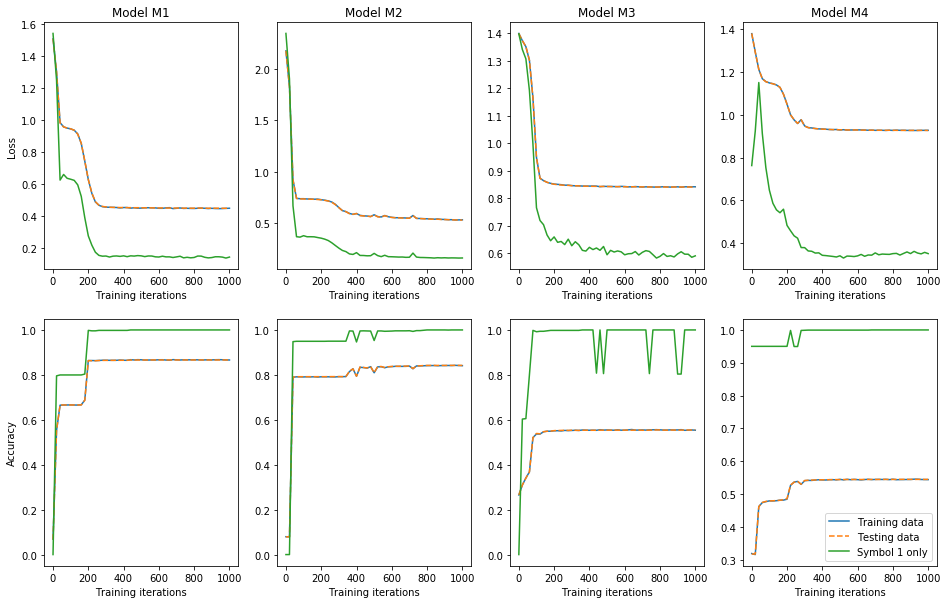

In [0]:
# Plot learning curves 

 M1 M2 M3 M4  sample visualisation


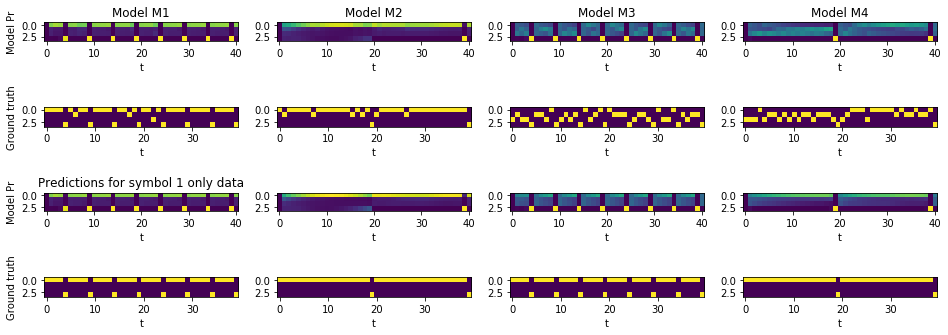

In [0]:
# Visualize performance on the test sequences:

# Sample generation of test sequence:
# get_minibatch(batch_size, num_tasks_per_batch, num_samples_per_task-1, p=[1.0, 0.0, 0.0])

### Bayesian Updates

 M2 M4  Final losses/accuracies
Testing Losses: [0.5124292750171825, 0.9238873414275103]
Symbol 1 only Losses: [0.10336116209546264, 0.3071518756221299]
Testing Accuracies: [0.8423235055027514, 0.5448896323161581]
Symbol 1 only Accuracies: [1.0, 1.0]

 M2 M4  Bayesian sample visualisation


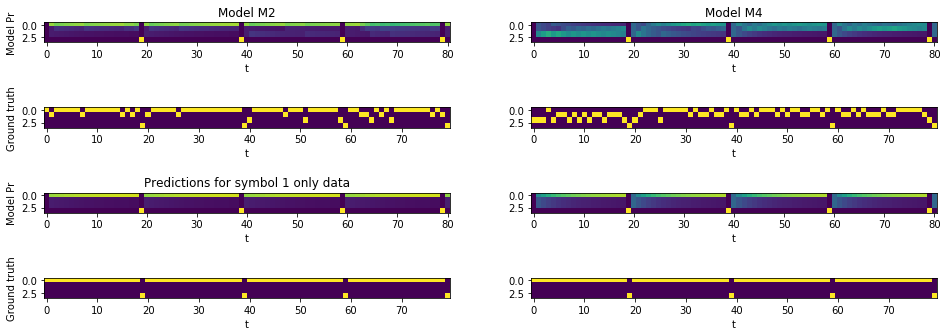

In [0]:
# Visualize and compare performance on the test sequences:print(" M1 M2 M3 M4  Final losses/accuracies")